# Exploring Data using GLMs

In [33]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

import statsmodels.api as sm

### Helper functions

In [34]:
def prepare_glm_data(data:pd.DataFrame) -> pd.DataFrame:
    _data = data.copy()
    bool_cols = _data.select_dtypes(include='bool').columns
    _data[bool_cols] = _data[bool_cols].astype(int)
    _data = sm.add_constant(_data)
    return _data

def evaluate_model(model:sm.GLM):
    print(f'Pseudo R-squared: {model.pseudo_rsquared():.2%}')
    print(f'Deviance: {model.deviance:,.2f}')
    print(f'Pearson Chi-squared: {model.pearson_chi2:,.2f}')
    print(f'BIC: {model.bic_llf:,.2f}')
    print(f'Average residual: {np.mean(model.resid_response)}')
    print(f'Residuals Std: {np.std(model.resid_response)}')

### Data Load

In [35]:
DATA_PATH = r'C:/Users/Nick/Documents/Data Science/Personal projects/car-price-prediction/data/clean/'
FILE_NAME = 'data_clean_20240811.csv'

data = pd.read_csv(DATA_PATH+FILE_NAME, sep=';')
print(f'{data.shape[0]} rows, {data.shape[1]} attributes')

17705 rows, 10 attributes


### Prepare data

In [36]:
X = data.drop(['FullName', 'Price', 'ProductionDate'], axis=1)
y = data['Price']

X_dummies = pd.get_dummies(X)

### Following the assumption from the EDA process...

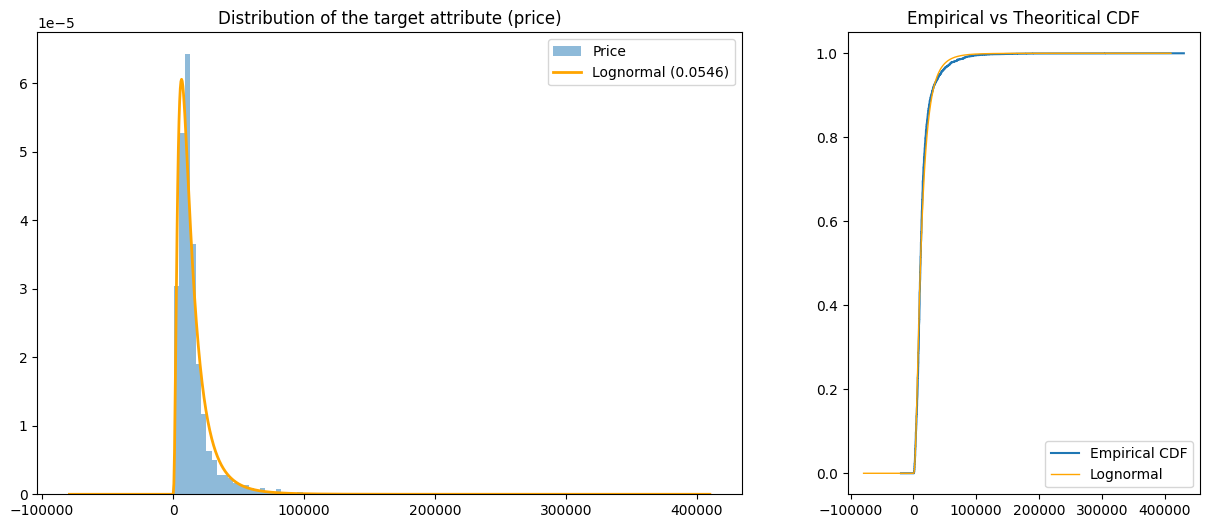

In [37]:
price_values = y.values

# fit a distribution
s, loc2, scale2 = stats.lognorm.fit(price_values)

lognorm_ks = stats.ks_1samp(price_values, stats.lognorm.cdf, args=(s, loc2, scale2)).statistic

# calculate the pdfs for plot
x_linspace = np.linspace(start=min(price_values)-80000, stop=max(price_values), num=1000)

lognorm_pdf = stats.lognorm.pdf(x_linspace, s, loc2, scale2)

# calculate the empirical cdf from sample and the theoritical choosen one
empirical_cdf = stats.ecdf(price_values).cdf
lognorm_cdf = stats.lognorm.cdf(x_linspace, s, loc2, scale2)

# make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 6), width_ratios=[2,1])

axs[0].hist(price_values, bins=100, density=True, label='Price', alpha=0.5)

axs[0].plot(x_linspace, lognorm_pdf, lw=2, c='orange', label=f'Lognormal ({lognorm_ks:.4f})')
axs[0].set_title('Distribution of the target attribute (price)')
axs[0].legend()

empirical_cdf.plot(axs[1], label='Empirical CDF')
axs[1].plot(x_linspace, lognorm_cdf, color='orange', lw=1, label='Lognormal')
axs[1].set_title('Empirical vs Theoritical CDF')
axs[1].legend()

plt.show()

In [38]:
# sm.families.family.Gaussian.links

# identity link function
glm_gaussian_identity = sm.GLM(np.log(y), prepare_glm_data(X_dummies), family=sm.families.Gaussian(link=sm.genmod.families.links.Identity())).fit()
# log link function
glm_gaussian_log = sm.GLM(np.log(y), prepare_glm_data(X_dummies), family=sm.families.Gaussian(link=sm.genmod.families.links.Log())).fit()
# identity link function
glm_gaussian_inversepower = sm.GLM(np.log(y), prepare_glm_data(X_dummies), family=sm.families.Gaussian(link=sm.genmod.families.links.InversePower())).fit()

In [39]:
print('---------Identity Link---------')
evaluate_model(glm_gaussian_identity)
print('---------Log Link---------')
evaluate_model(glm_gaussian_log)
print('---------InvPower Link---------')
evaluate_model(glm_gaussian_inversepower) # best model

---------Identity Link---------
Pseudo R-squared: 96.42%
Deviance: 2,378.66
Pearson Chi-squared: 2,378.66
BIC: 15,204.03
Average residual: 1.531078129132993e-14
Residuals Std: 0.36653703935903914
---------Log Link---------
Pseudo R-squared: 96.77%
Deviance: 2,323.90
Pearson Chi-squared: 2,323.90
BIC: 14,791.75
Average residual: 0.00013146950979302287
Residuals Std: 0.3622934146426768
---------InvPower Link---------
Pseudo R-squared: 96.87%
Deviance: 2,307.62
Pearson Chi-squared: 2,307.62
BIC: 14,667.28
Average residual: 2.6389199568617207e-05
Residuals Std: 0.36102219526966634


#### Remove independent variables with p-value greater than 5% and re-fit the model

In [40]:
best_model = glm_gaussian_inversepower

In [41]:
threshold = .05
cols_to_drop = best_model.pvalues[best_model.pvalues >= threshold].index.values
if 'const' in cols_to_drop:
    X_dummies_dropped = X_dummies.drop(cols_to_drop[1:], axis=1)
else:
    X_dummies_dropped = X_dummies.drop(cols_to_drop, axis=1)

# re-fit the model
best_model_dropped = sm.GLM(np.log(y), prepare_glm_data(X_dummies_dropped), family=sm.families.Gaussian(sm.families.links.Log())).fit()

# evaluate
evaluate_model(best_model_dropped)


# Worse performance than the initial (?)

Pseudo R-squared: 96.77%
Deviance: 2,324.03
Pearson Chi-squared: 2,324.03
BIC: 14,753.65
Average residual: 0.00013137446124493498
Residuals Std: 0.3623041007409891


### Residual Analysis

In [42]:
model = glm_gaussian_inversepower

In [43]:
res = stats.ks_1samp(model.resid_response, stats.norm.cdf, args=(np.mean(model.resid_response), np.std(model.resid_response)))
res

KstestResult(statistic=0.08856943635498304, pvalue=2.687596628730128e-121, statistic_location=0.25214440051187204, statistic_sign=1)

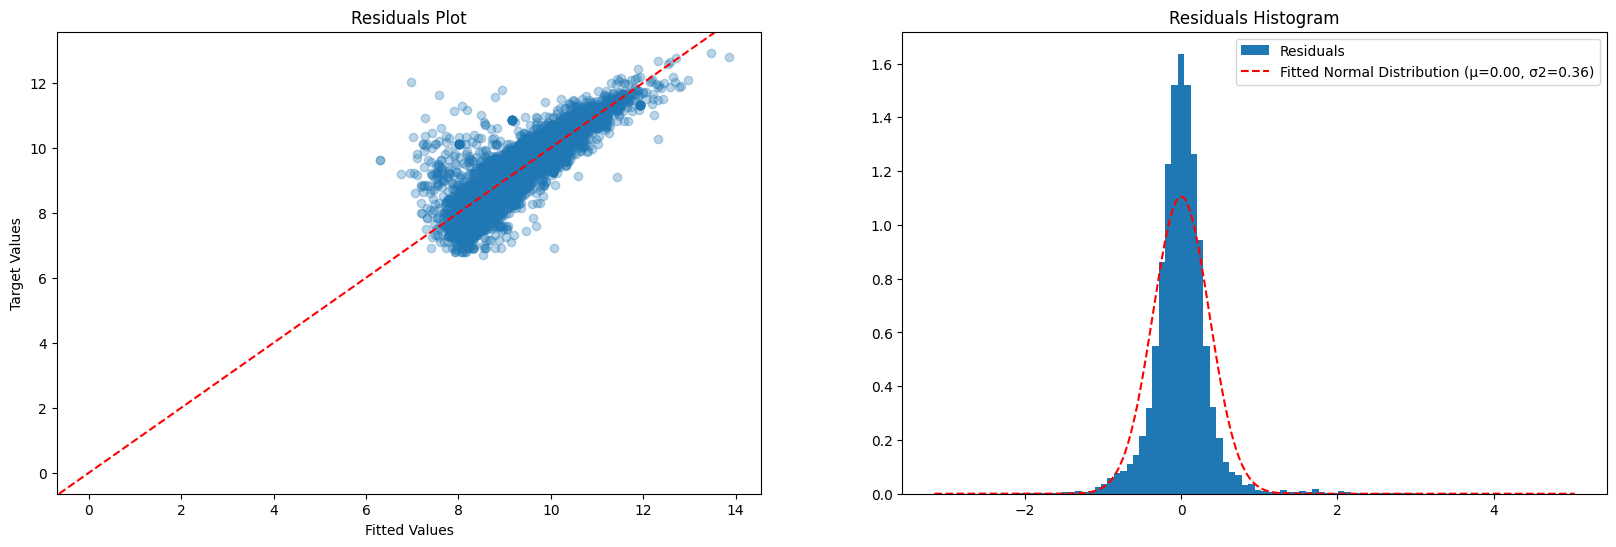

In [45]:
fig, axs = plt.subplots(1,2, figsize=(20,6), gridspec_kw={'hspace':.25})

axs[0].scatter(model.fittedvalues, np.log(y), alpha=.3)
axs[0].axline((0,0), slope=1, color='red', ls='--')
axs[0].set_xlabel('Fitted Values')
axs[0].set_ylabel('Target Values')
axs[0].title.set_text('Residuals Plot')

x_linspace = np.linspace(start=min(model.resid_response), stop=max(model.resid_response), num=1000)
x_pdf = stats.norm.pdf(x_linspace, np.mean(model.resid_response), np.std(model.resid_response))

axs[1].hist(model.resid_response, bins=100, density=True, label='Residuals')
axs[1].plot(x_linspace, x_pdf, c='red', ls='--', label=f'Fitted Normal Distribution (μ={np.mean(model.resid_response):.2f}, σ2={np.std(model.resid_response):.2f})')
axs[1].legend()
axs[1].title.set_text('Residuals Histogram')

plt.show()

### Interpretation of results

[TO DO] Why base prediction is so big ???

In [281]:
def numeric_format(x):
    if isinstance(x, (float, int)):
        return f'{x:,.5f}'
    else:
        return x

betas = glm_gaussian_inversepower.params
pvalues = glm_gaussian_inversepower.pvalues

base_prediction = np.exp(1 / betas['const'])
impact_df = pd.DataFrame(columns=['predictor', 'coefficient', 'pvalue', 'impact'])
for predictor in betas.index[1:]:
    prediction = np.exp(1 / (betas[predictor] + betas['const']))
    impact = prediction - base_prediction

    impact_df.loc[len(impact_df)] = (predictor, betas[predictor], pvalues[predictor], impact)

impact_df = impact_df.sort_values('impact', ascending=False).reset_index(drop=True)

# keep only the statistically significat predictors
impact_df = impact_df[impact_df['pvalue'] <= .05].reset_index(drop=True)

impact_df.map(numeric_format)

,predictor,coefficient,pvalue,impact
0,Name_Jaguar,-0.00370,0.00000,"2,515,526.75328"
1,Name_Land-Rover,-0.00235,0.00000,"1,316,081.51569"
2,Name_Porsche,-0.00227,0.00000,"1,259,146.67163"
3,Name_Mercedes-Benz,-0.00215,0.00000,"1,171,868.41667"
4,Name_Bmw,-0.00101,0.00000,"476,331.30294"
5,Name_Audi,-0.00063,0.00009,"282,554.52078"
6,Horsepower,-0.00002,0.00000,"10,284.76040"
7,CubicCapacity,-0.00000,0.00000,698.43416
8,Klm,0.00000,0.00000,-10.96819
9,Age,0.00061,0.00000,"-236,647.00519"
